In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

from pysolar.solar import *
import pytz
import shap
import pickle
import multiprocessing

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()

# Perameters


In [2]:
cheap_node_list = ['001e063059c2', '001e06305a61', '001e06305a6c', '001e06318cd1',
                   '001e06323a05', '001e06305a57', '001e06305a6b', '001e06318c28',
                   '001e063239e3', '001e06323a12']

cheap_node_id = '001e06305a6b'
node_id = '10004098'
gps_node_id = '001e0610c2e9'
dir_out = '../figures/' + cheap_node_id + '/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1))#.astype(str)
#for i in range(len(wavelengths)):
#    wavelengths[i] = wavelengths[i] + 'nm'
#wavelengths = list(wavelengths)

## Read Data

In [3]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + node_id + '_'+ cheap_node_id +'.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')
df = df[(df.index.date != datetime.date(2019, 12, 31)) # Minolta was covered in these dates
       &(df.index.date != datetime.date(2019, 12, 27))
       &(df.index.date != datetime.date(2020,  1,  1))
       &(df.index.date != datetime.date(2020,  1,  2))]
#        &(df.index.date != datetime.date(2020, 2, 14))
#        &(df.index.date != datetime.date(2020, 2, 21))] 

In [4]:
features = [#'cloudPecentage', 'allRed', 'allGreen', 'allBlue',
            #'skyRed', 'skyGreen', 'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue',
            'Violet', 'Blue', 'Green', 'Yellow', 'Orange', 'Red',
            'Temperature', 'Pressure', 'Humidity',
            #'Latitude', 'Longitude', 'Altitude',
            #'NH3', 'CO', 'NO2', 'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'CO2',
            'Luminosity', 'IR', 'Full', 'Visible', 'Lux',
            'UVA', 'UVB', 'Visible Compensation','IR Compensation', 'UV Index',
            'Zenith']
features = np.array(features)
len(features)

20

In [5]:
targets = df.columns[-421-1:-1].values # skip Illuminance, keep Wavelengths
print(features)
print(targets[[0,-1]])

X = df[features]
Y = df[targets] # MLP and scaler use multi output

['Violet' 'Blue' 'Green' 'Yellow' 'Orange' 'Red' 'Temperature' 'Pressure'
 'Humidity' 'Luminosity' 'IR' 'Full' 'Visible' 'Lux' 'UVA' 'UVB'
 'Visible Compensation' 'IR Compensation' 'UV Index' 'Zenith']
['360nm' '780nm']


## Prepare Data  For Training

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# scale the data
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)


In [8]:
n_components = 18

DR = 'PCA'
Cluster = 'None'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)

X_train_scaled_DR = pca.fit_transform(X_train_scaled)
X_test_scaled_DR = pca.transform(X_test_scaled)

X_train_scaled_DR = pd.DataFrame(X_train_scaled_DR)
X_test_scaled_DR = pd.DataFrame(X_test_scaled_DR)
print(pca.explained_variance_)

# save pca model
dir_DR = '../models/' + cheap_node_id + '/'
if not os.path.exists(dir_DR):
    os.mkdir(dir_DR)

fn_DR = dir_DR + DR + '.sav'
pickle.dump(pca, open(fn_DR, 'wb'))

[1.34800963e+01 2.08790813e+00 1.55495757e+00 1.10210674e+00
 8.12184035e-01 4.13857172e-01 2.69673787e-01 1.73131986e-01
 4.84529514e-02 4.22295245e-02 1.42009996e-02 1.10584758e-03
 9.60324112e-05 4.81412873e-05 1.91574834e-05 5.94290405e-06
 5.37566942e-06 4.52938970e-06]


In [9]:
scaler_x2 = StandardScaler()
X_train_scaled_DR_scaled = scaler_x2.fit_transform(X_train_scaled_DR)
X_test_scaled_DR_scaled = scaler_x2.transform(X_test_scaled_DR)

# Model Start from here

## Model for Whole Spectrum

In [ ]:
for hidden_layer_sizes in [(128,128),
#                            (64,64,64,64),
#                            (32,32,32,32,32),
#                            (512),
#                            (256),
#                            (256,256)
#                           ]:
#     print(hidden_layer_sizes)
#     activation ='relu'
#     solver = 'adam'
#     alpha=1e-5 # L2 penalty (regularization term) parameter
#     learning_rate = 'constant'

#     # include layer structure and activation function
#     structure = '_' + DR + str(n_components) + \
#                 '_' + str(hidden_layer_sizes)[1:-1].replace(', ','_') + \
#                 '_' + activation
    
#     start_time = time.time()
#     regr = MLPRegressor(random_state=RANDOM_STATE,
#                         hidden_layer_sizes=hidden_layer_sizes,
#                         activation = activation,
#                         solver = solver,
#                         alpha = alpha,
#                         learning_rate = learning_rate,
#                         verbose = False
#                         )
#     regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)

#     print("--- %s seconds ---" % (time.time() - start_time))
    
#     # save model
#     dir_model = '../models/' + cheap_node_id + '/'
#     if not os.path.exists(dir_model):
#         os.mkdir(dir_model)
#     dir_model += 'whole/'
#     if not os.path.exists(dir_model):
#         os.mkdir(dir_model)

#     fn_model = dir_model + 'MLP_whole' + structure + '.sav'
#     pickle.dump(regr, open(fn_model, 'wb'))
    
    
#     # plot 10 % of the data
#     Y_train_pred = scaler_y.inverse_transform(
#                         regr.predict( X_train_scaled_DR_scaled )
#                         ) # for train
#     Y_test_pred = scaler_y.inverse_transform(
#                         regr.predict( X_test_scaled_DR_scaled )
#                         )# for image
#     #Y_test_pred = regr.predict(X_test) # for test score

#     train_score =  r2_score(Y_train, Y_train_pred)
#     test_score = r2_score(Y_test, Y_test_pred)

#     y_min = np.amin(Y_train.values)
#     y_max = np.amax(Y_train.values)
#     y_line = np.linspace(y_min,y_max,100)

#     plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
#     plt.rcParams.update({'font.size': 20})
#     fig, ax = plt.subplots()
#     plt.plot(y_line,y_line, '-k', label='y=x')

#     length_sample = len(Y_test)//10
#     plt.scatter(Y_train[:length_sample],Y_train_pred[:length_sample], s=1, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
#     plt.scatter(Y_test[:length_sample],Y_test_pred[:length_sample], s=1, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
#     plt.xlim((y_min,y_max))
#     plt.ylim((y_min,y_max))
#     ax.set_title('Predicted vs Actual for Whole Spectrum')
#     ax.set_xlabel('Actual Value')
#     ax.set_ylabel('Predicted Value')
#     plt.legend( loc='lower right')
#     plt.grid()
#     plt.tight_layout()

#     if not os.path.exists(dir_out + 'whole'):
#         os.mkdir(dir_out + 'whole')
#     plt.savefig(dir_out + 'whole' +'/MLP_performance_whole'+structure+'.png')


In [10]:
hidden_layer_sizes=(64,128,256)
#hidden_layer_sizes=(128,128,128,128)
#hidden_layer_sizes=(512, 512, 256, 256)
#hidden_layer_sizes=(128,128,128,128,128,128)
#hidden_layer_sizes=(128,128,128,128,128)

activation ='relu'
solver = 'adam'
alpha=1e-5 # L2 penalty (regularization term) parameter, default 1e-5
learning_rate = 'constant'

# include layer structure and activation function
structure = '_' + DR + str(n_components) + \
            '_' + str(hidden_layer_sizes)[1:-1].replace(', ','_') + \
            '_' + activation

In [11]:
start_time = time.time()

regr = MLPRegressor(random_state = RANDOM_STATE,
                    hidden_layer_sizes = hidden_layer_sizes,
                    activation = activation,
                    solver = solver,
                    alpha = alpha,
                    learning_rate = learning_rate,
                    verbose = True
                    )
regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)

# fine tune the model
regr.warm_start = True
regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)

regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

Iteration 1, loss = 0.01353132
Iteration 2, loss = 0.00222309
Iteration 3, loss = 0.00170361
Iteration 4, loss = 0.00147448
Iteration 5, loss = 0.00134106
Iteration 6, loss = 0.00123807
Iteration 7, loss = 0.00114202
Iteration 8, loss = 0.00109395
Iteration 9, loss = 0.00102612
Iteration 10, loss = 0.00100466
Iteration 11, loss = 0.00096343
Iteration 12, loss = 0.00091947
Iteration 13, loss = 0.00089234
Iteration 14, loss = 0.00087843
Iteration 15, loss = 0.00084553
Iteration 16, loss = 0.00083907
Iteration 17, loss = 0.00080475
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 18, loss = 0.00058542
Iteration 19, loss = 0.00055553
Iteration 20, loss = 0.00054714
Iteration 21, loss = 0.00054126
Iteration 22, loss = 0.00053321
Iteration 23, loss = 0.00052765
Iteration 24, loss = 0.00052434
Iteration 25, loss = 0.00051614
Iteration 26, loss = 0.00051367
Iteration 27, loss = 0.00051219
Iteration 28, loss = 0.00050623
Iteration 29, loss = 0.

In [12]:
# save model
dir_model = '../models/' + cheap_node_id + '/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)
dir_model += 'whole/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)

fn_model = dir_model + 'MLP_whole' + structure + '.sav'
pickle.dump(regr, open(fn_model, 'wb'))


In [13]:
#dir_model = '../models/' + cheap_node_id + '/'  + 'whole/'
#fn_model = dir_model + 'MLP_whole' + structure + '.sav'
#regr = pickle.load(open(fn_model, 'rb'))


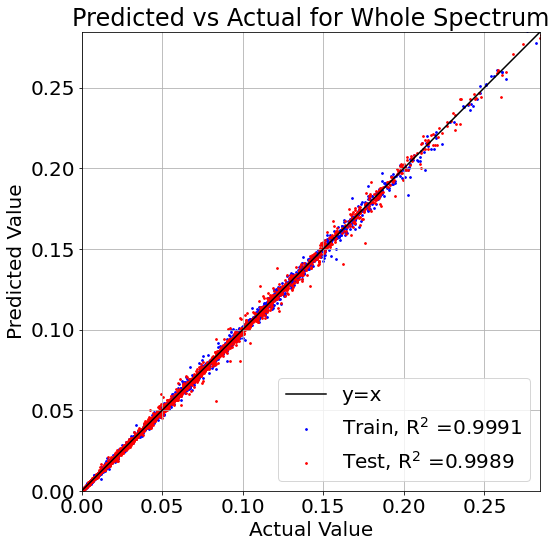

In [17]:
from sklearn.metrics import r2_score

Y_train_pred = scaler_y.inverse_transform(
                    regr.predict( X_train_scaled_DR_scaled )
                    ) # for train
train_score = r2_score(Y_train, Y_train_pred)

Y_test_pred = scaler_y.inverse_transform(
                    regr.predict( X_test_scaled_DR_scaled )
                    )# for test
test_score = r2_score(Y_test, Y_test_pred)

# flatten
Y_train_flatten = Y_train.values.flatten()
Y_train_pred_flatten = Y_train_pred.flatten()

Y_test_flatten = Y_test.values.flatten()
Y_test_pred_flatten = Y_test_pred.flatten()

Y_min = np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)

y_line = np.linspace(Y_min,Y_max,100)


plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten), 5000, replace = False)
plt.scatter(Y_train_flatten[id_train],Y_train_pred_flatten[id_train], s=3, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
id_test = np.random.choice(len(Y_test_flatten), 5000, replace = False)
plt.scatter(Y_test_flatten[id_test],Y_test_pred_flatten[id_test], s=3, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim(Y_min, Y_max)
plt.ylim(Y_min, Y_max)

ax.set_title('Predicted vs Actual for Whole Spectrum')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + 'whole'):
    os.mkdir(dir_out + 'whole')
plt.savefig(dir_out + 'whole' +'/MLP_performance_whole'+structure+'.png')


{datetime.date(2019, 12, 26): 1769,
 datetime.date(2020, 1, 23): 791,
 datetime.date(2020, 1, 27): 271,
 datetime.date(2020, 1, 31): 594,
 datetime.date(2020, 2, 21): 1407,
 datetime.date(2020, 2, 14): 3654,
 datetime.date(2020, 1, 24): 326,
 datetime.date(2020, 2, 1): 418,
 datetime.date(2020, 3, 1): 404,
 datetime.date(2020, 1, 28): 167,
 datetime.date(2020, 2, 25): 1,
 datetime.date(2020, 2, 26): 157,
 datetime.date(2019, 12, 10): 12,
 datetime.date(2020, 3, 21): 115,
 datetime.date(2020, 2, 20): 76,
 datetime.date(2020, 3, 24): 121,
 datetime.date(2020, 2, 7): 54,
 datetime.date(2020, 3, 19): 2}

[<matplotlib.lines.Line2D at 0x7ff1596d9890>]

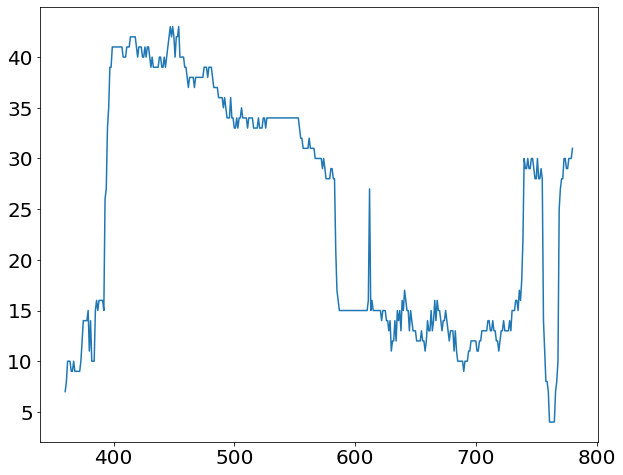

In [27]:
bads = {}
bads_var = {}
counts = []
for i in range(len(targets)):
    var = targets[i]
    temp = Y_train[var][ (Y_train[var]/Y_train_pred[:,i] > 1.2 ) & (Y_train[var]>0.05)]
    # count bad dates
    for date in temp.index.date:
        if date in bads:
            bads[date] += 1
        else:
            bads[date] = 1
    # count bad wavelengths
    var_i = int(var[:-2])
    
    bads_var[var_i] = len(temp)
    counts.append(len(temp))
        

display(bads)


plt.plot(wavelengths, counts)


In [18]:
train_scores = []
test_scores = []
for i in range(len(wavelengths)):
    train_scores.append( r2_score(Y_train.iloc[:,i], Y_train_pred[:,i]) )
    test_scores.append( r2_score(Y_test.iloc[:,i], Y_test_pred[:,i]) )


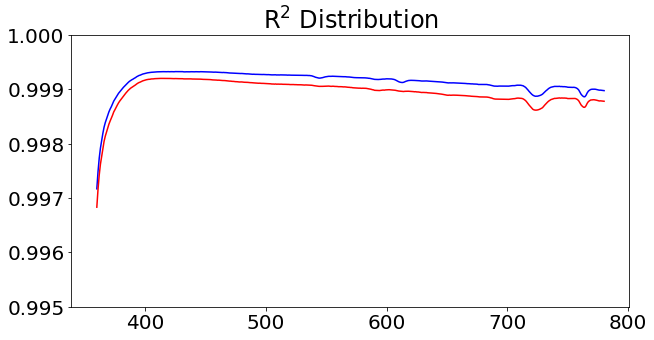

In [21]:
plt.rcParams["figure.figsize"] = (10, 5) # (w, h)
plt.plot(np.array(range(360,780+1)),train_scores, 'b', label = 'Train')
plt.plot(np.array(range(360,780+1)),test_scores, 'r', label = 'Test')
plt.ylim(0.995,1)
plt.title("R$^2$ Distribution")
plt.savefig(dir_out + 'whole' + '/MLP_R2' + structure + '.png')

In [63]:
# Create object that can calculate shap values
num_shap = 100
X_sample = shap.sample(X_test_scaled_DR_scaled, 100)
explainer = shap.KernelExplainer(regr.predict, X_sample)
# Calculate shap_values
shap_values = explainer.shap_values(X_sample)
shap_values

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [59]:
# Create object that can calculate shap values
num_shap = 10
explainer = shap.KernelExplainer(regr.predict, X_train_scaled_DR_scaled[:num_shap])
# Calculate shap_values
shap_values = explainer.shap_values(X_train_scaled_DR_scaled[:num_shap])
shap_values

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [53]:
len(shap_values)

100

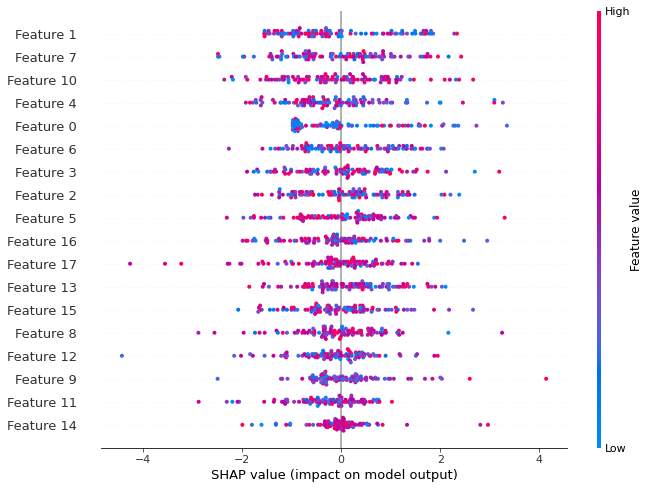

In [54]:
# plot
max_display = n_components
shap.summary_plot(shap_values, X_train_scaled_DR_scaled,
                  plot_size=(10,max_display/2.5),#'auto'
                  max_display = max_display,
                  show=False,
                  plot_type = 'dot'
                 )
plt.tight_layout()
# plt.savefig(dir_out + 'whole' + '/MLP_shap_whole' + structure + '.png')

In [46]:
# plot
max_display = n_components
shap.summary_plot(np.mean(shap_values, axis = 0), X_train_scaled_DR_scaled[:num_shap],
                  plot_size=(10,max_display/2.5),#'auto'
                  max_display = max_display,
                  show=False,
                  plot_type = 'dot'
                 )
plt.tight_layout()
# plt.savefig(dir_out + 'whole' + '/MLP_shap_whole' + structure + '.png')

AssertionError: Summary plots need a matrix of shap_values, not a vector.

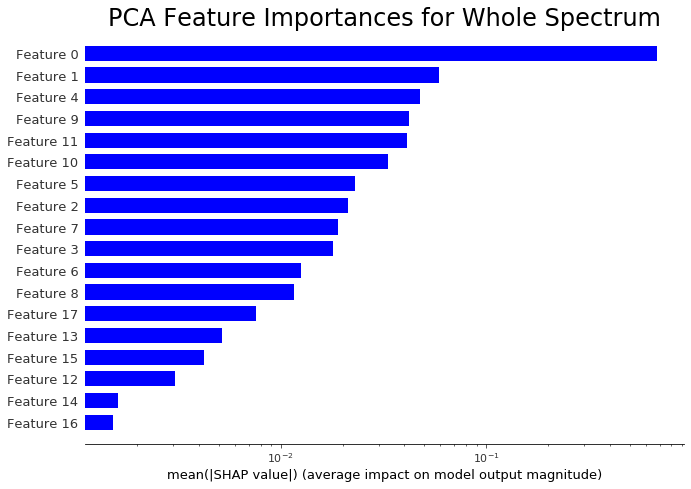

In [23]:
shap.summary_plot(np.mean(shap_values, axis = 0), X_train_scaled_DR_scaled[:num_shap],
                  plot_size=(10,max_display/2.5),#'auto'
                  color = 'blue',
                  max_display = max_display,
                  show=False,
                  plot_type = 'bar'
                 )
plt.xscale("log")
plt.title('PCA Feature Importances for Whole Spectrum')
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_PCAImportances_whole' + structure +'.png')

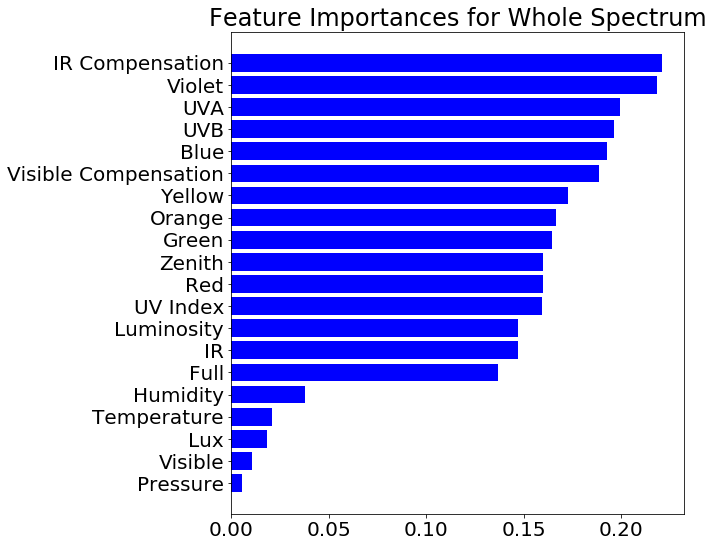

In [26]:
# rank feature inportance
num_features = len(features)
importances_pca = np.mean(np.abs(np.mean(shap_values, axis = 0)), axis = 0)
importances = np.abs(np.dot(importances_pca, pca.components_))
#std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

var_sorted = features[indices]
var_imp_sorted = importances[indices]

plt.rcParams["figure.figsize"] = (10, num_features/2.5) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features],
        var_imp_sorted[:num_features], color = 'blue',
        #yerr=std[indices][:num_features], ecolor='black',
        align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Feature Importances for Whole Spectrum')
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_Importances_whole' + structure +'.png')

## Compare Full Spectrum with Prediction

In [78]:
year = 2019
month = 12
day = 31
hour = 11+6
jetlag = 6
date_string = '%04d-%02d-%02d %02d:00:00' % (year, month, day, hour)

In [79]:
iwant = (X.index == date_string)

In [80]:
wavelengths = np.array(range(360,780+1))

x1 = X[iwant].index.values
y1 = y[iwant].values
y1_pred = regr.predict(X[iwant])

In [81]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
spectrum = y1
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, np.max(spectrum)*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y2)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y2), np.max(y2))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, np.max(spectrum)*1.1, color='w')

ax.set_title('Spectrum: %02d/%02d/%02d %02d:00' % (year, month, day, hour-jetlag))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Intensity')

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d.png' % (year, month, day, hour-jetlag))
#plt.close()

In [82]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
spectrum = y1_pred
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, np.max(spectrum)*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y2)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y2), np.max(y2))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, np.max(spectrum)*1.1, color='w')
ax.set_title('Predicted Spectrum: %02d/%02d/%02d %02d:00' % (year, month, day, hour-jetlag))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Intensity')

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d_pred.png' % (year, month, day, hour-jetlag))
#plt.close()